In [2]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

# Auto Dataset

In [34]:
# load the data
auto_df = pd.read_csv(r"datasets/auto-mpg.csv")
auto_df.rename(columns={"model year": "year", "car name": "name"}, inplace=True)
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [35]:
# we can see that the horsepower column dtype is object, indicating  that it has non-numeric values
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   year          398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [37]:
# Here we can see that some of the horsepower values are "?", we can replace this by the column mean.
# There are other ways to do this, but the ratio of the missing values to the number of rows (9:398)
# is not big, and replacing by mean is unlikely to affect the results.

auto_df.loc[~auto_df['horsepower'].astype(str).str.isdigit()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


In [38]:
# find the mean of the column and use it to replace the 9 missing values.

hp_mean = auto_df[auto_df["horsepower"] != '?']['horsepower'].astype(int).mean()
auto_df["horsepower"] = auto_df["horsepower"].replace('?', hp_mean).astype(int)

## Simple linear regression with horsepower as predictor

In [39]:
slr_model = ols(formula="mpg ~ horsepower", data=auto_df).fit()

print(slr_model.params)
print(slr_model.summary())

Intercept     40.005639
horsepower    -0.157866
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     582.5
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           8.54e-80
Time:                        11:11:25   Log-Likelihood:                -1202.6
No. Observations:                 398   AIC:                             2409.
Df Residuals:                     396   BIC:                             2417.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

### Is there a relationship between horsepower and mpg?
Since p-value is very low, below 0.05, then the null hypothesis stating that the coefficient of this variable is 0 can be rejected. Therefore, is a relationship between them.

### How strong is the relationship?
The R-squared value is 0.6, indicating that 60% of the variability in the response can be explained by the predictor. 

### Is the relationship between the predictor and the response positive or negative?
The coefficient is equal to -0.1578 therefore the relationship is negative, meaning that as the horespower increases, mpg tends to decrease.



### TODO: Explain the difference between confidence and prediction intervals

## What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

As shown below, the mean prediction is 24.53 with 95% confidence interval of [24.3, 25.03] and prediction interval of [14.73, 34.33]

In [41]:
predictions = slr_model.get_prediction(pd.DataFrame([98], columns=['horsepower']))
summary_frame = predictions.summary_frame(alpha=0.05)
summary_frame

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,24.534753,0.253111,24.037144,25.032362,14.734269,34.335238


## Plot response and predictor

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

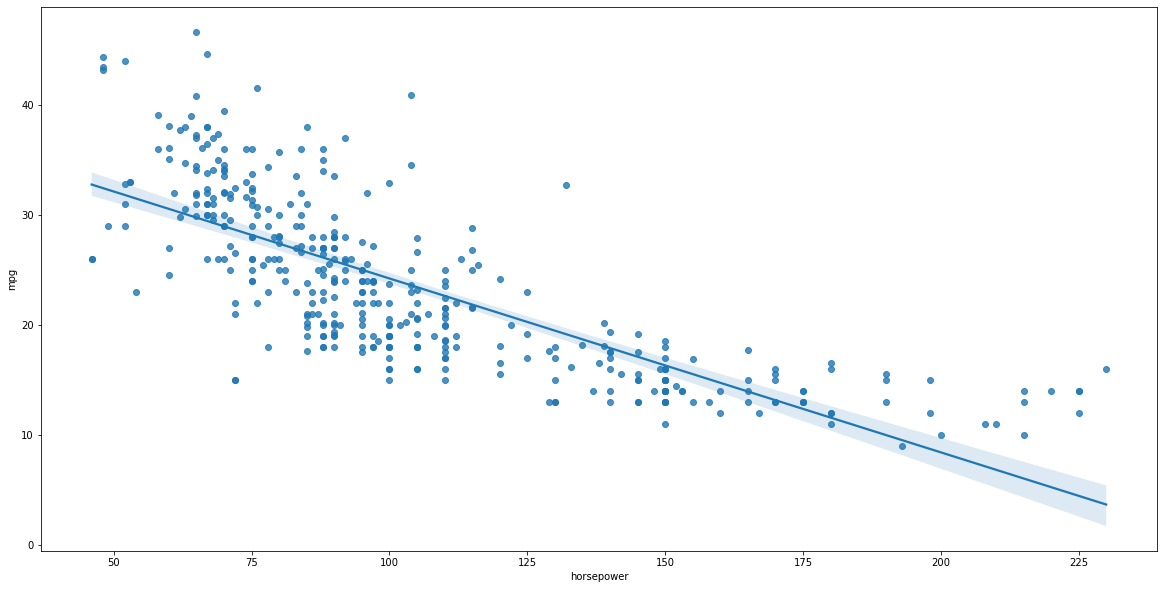

In [44]:
import seaborn as sns

sns.regplot(x="horsepower", y="mpg", data=auto_df)

## Diagnostic plots

As shown below in the residuals versus horsepower plot, the residuals don't seem random but rather have a certain trend which may indicate the presence of non-linearity in the data. This may be solved by performing some transformations like squaring the horsepower. 

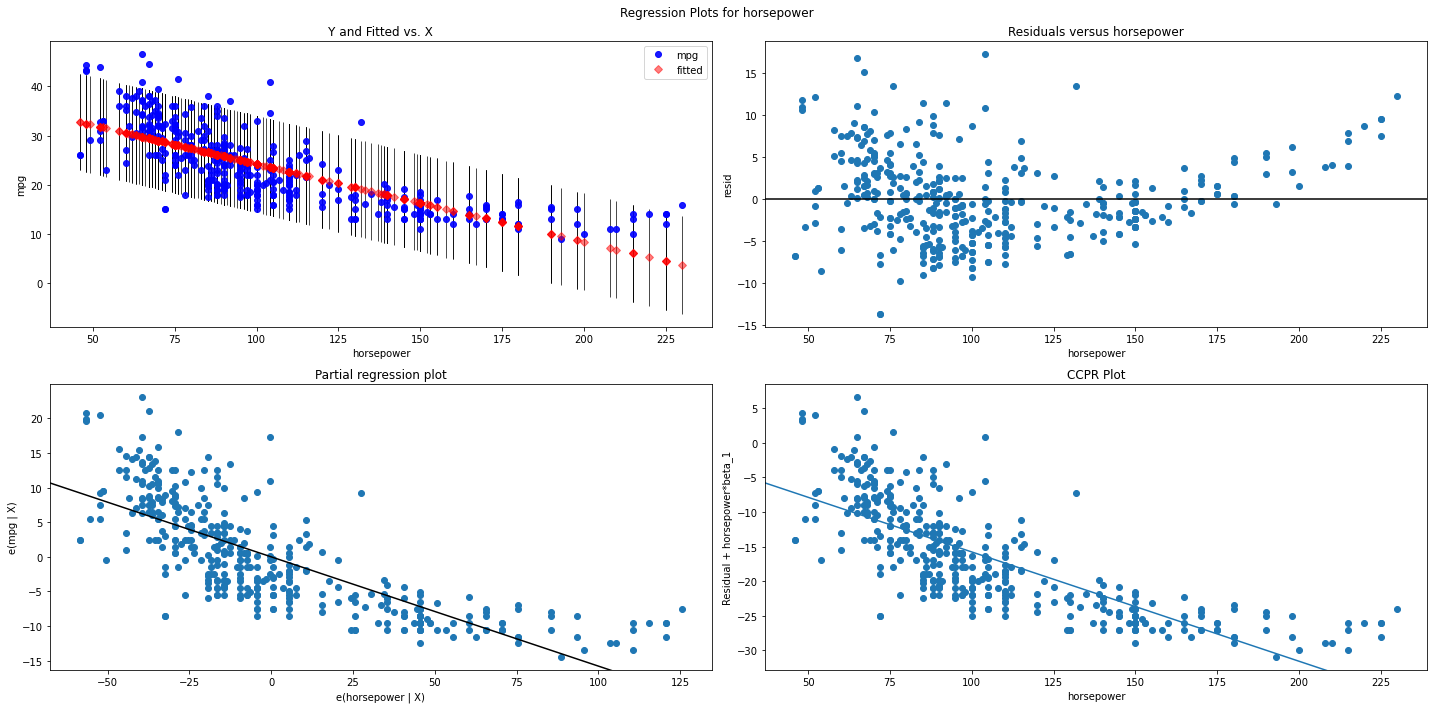

In [45]:
fig = sm.graphics.plot_regress_exog(slr_model, "horsepower")
fig.tight_layout(pad=1.0)

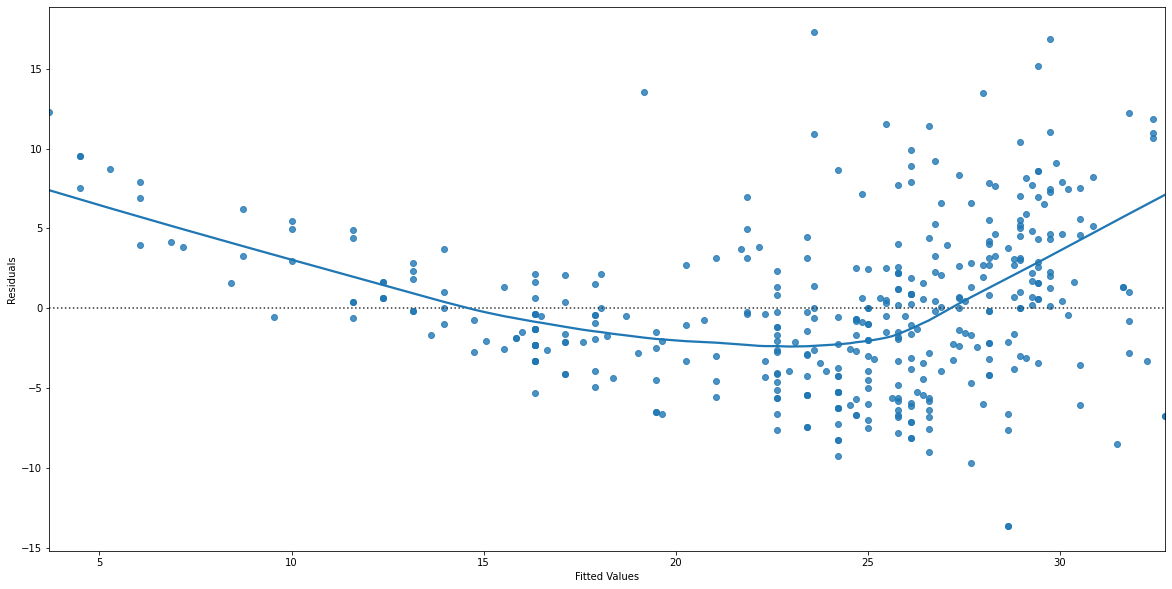

In [46]:
# To better see the pattern of the residuals better, we can fit a line to the residuals.

ax = sns.residplot(x=slr_model.fittedvalues, y=slr_model.resid, lowess=True)
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")
plt.show()

# Multiple linear regression on auto dataset

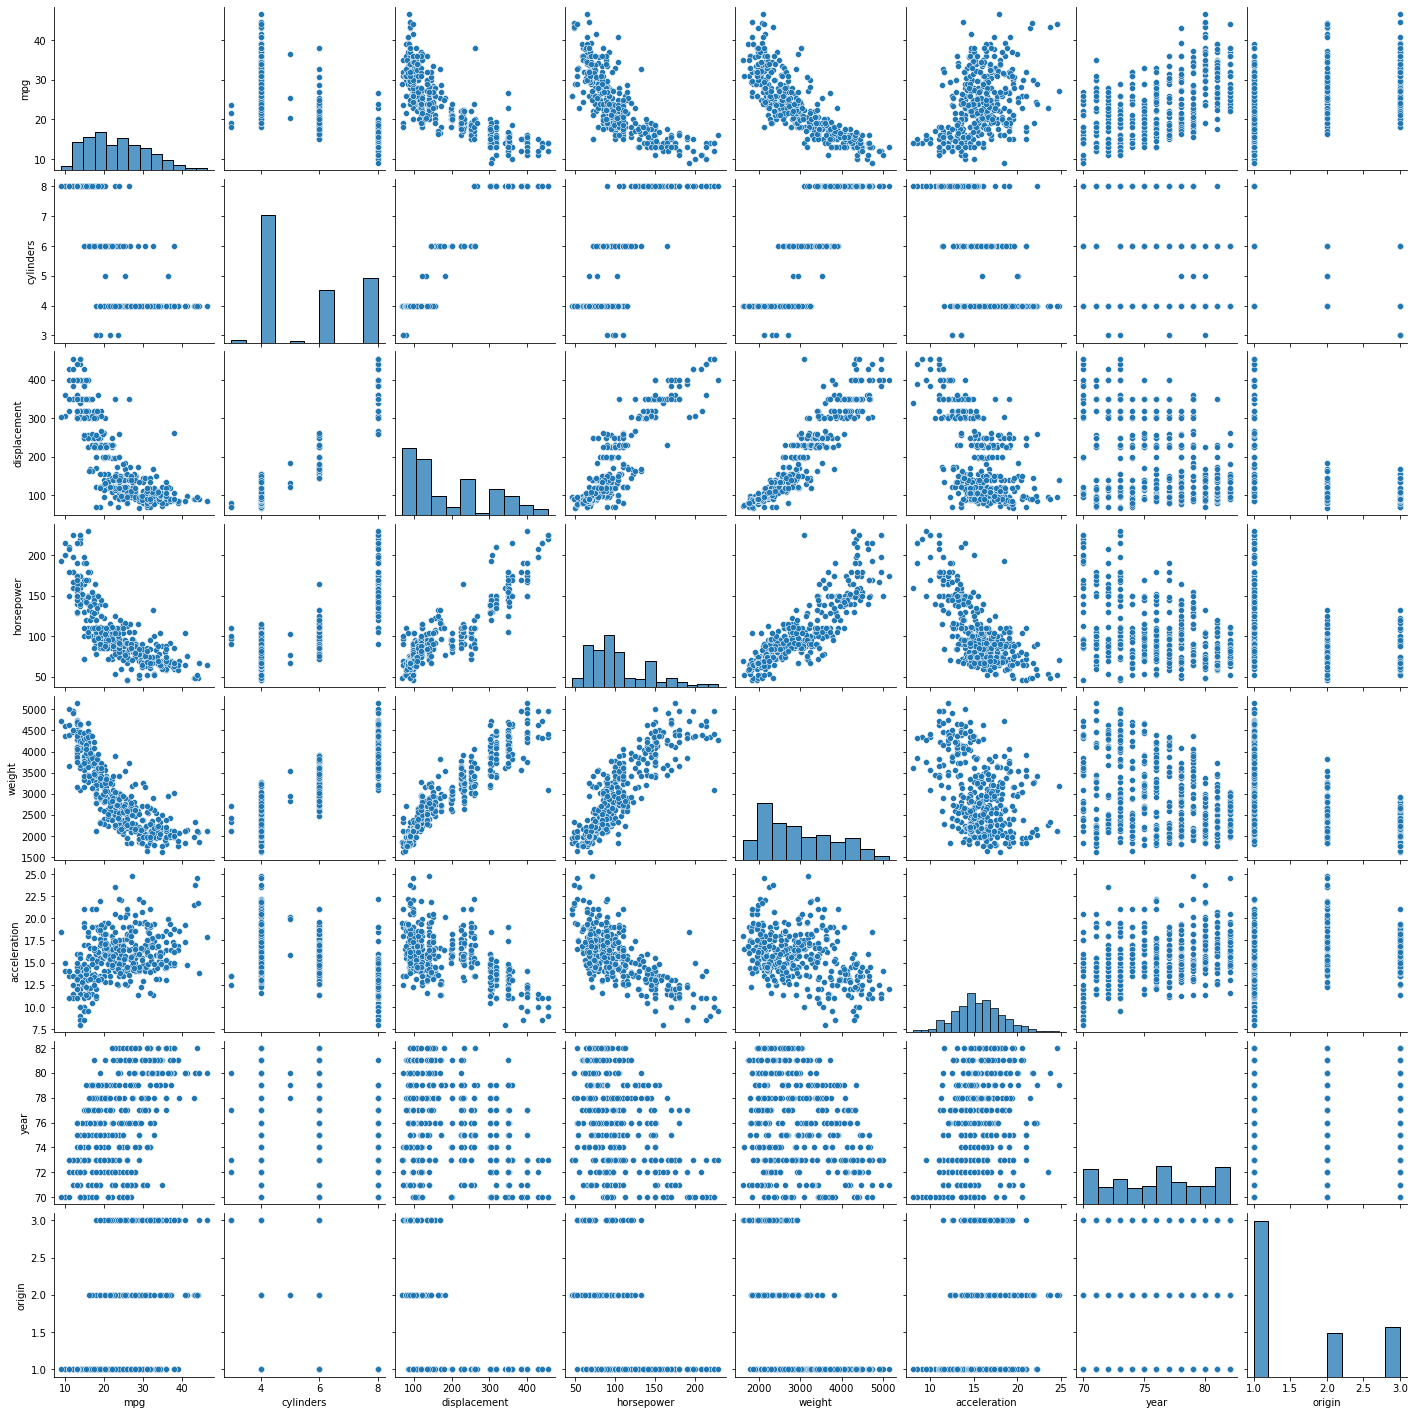

In [47]:
# To understand the relationship between predictors, we can use a pairwise scatter plot.
sns.pairplot(auto_df)

<AxesSubplot:>

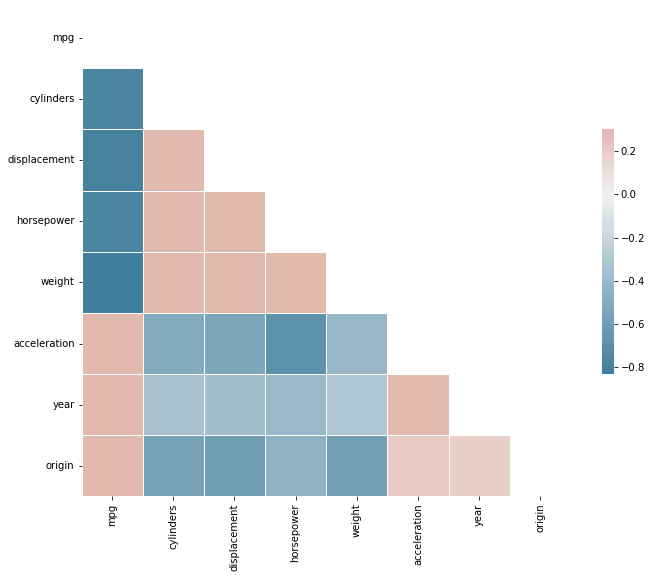

In [50]:
# As shown the pairplot above, some variables like weight and displacement seem to be correlated.
# We can compute correlations between columns to better see this. 

# Correlation plot, source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = auto_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [52]:
# Here we fit a model using all the predictors except name to predict mpg
all_columns = "+".join(auto_df.columns[1:-1])

mlr_model = ols(formula=f"mpg ~ {all_columns}", data=auto_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     255.4
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          2.25e-141
Time:                        11:26:21   Log-Likelihood:                -1040.3
No. Observations:                 398   AIC:                             2097.
Df Residuals:                     390   BIC:                             2129.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -18.0517      4.584     -3.938   

### Is there a relationship between the predictors and the response?

The p-value for 3 predictors (cylinders, horsepower, and acceleration) is high indicating that there is no correlation between these independent variables and the response, therefore the null hypothesis should NOT be rejected. For other predictors, the p-value is small enough to indicate that there is a relationship.

### What does the coefficient for the year variable suggest?
It suggests that the newer the production year is, the higher the mpg is. For every unit increase in the year, holding other predictors constant, the mpg increases by 0.757.

## Diagnostic Plots
We can see in the residual plot that the residuals are not random but have a trend which indicates the possible presence of non-linearity. Additionally, we can see in the Q-Q plot that most of the points actually line on the diagonal line, but as we approach the right end of the graph, points start to deviate indicating a heavier tail on the right side of the distribution.

C:\Users\amrsh\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


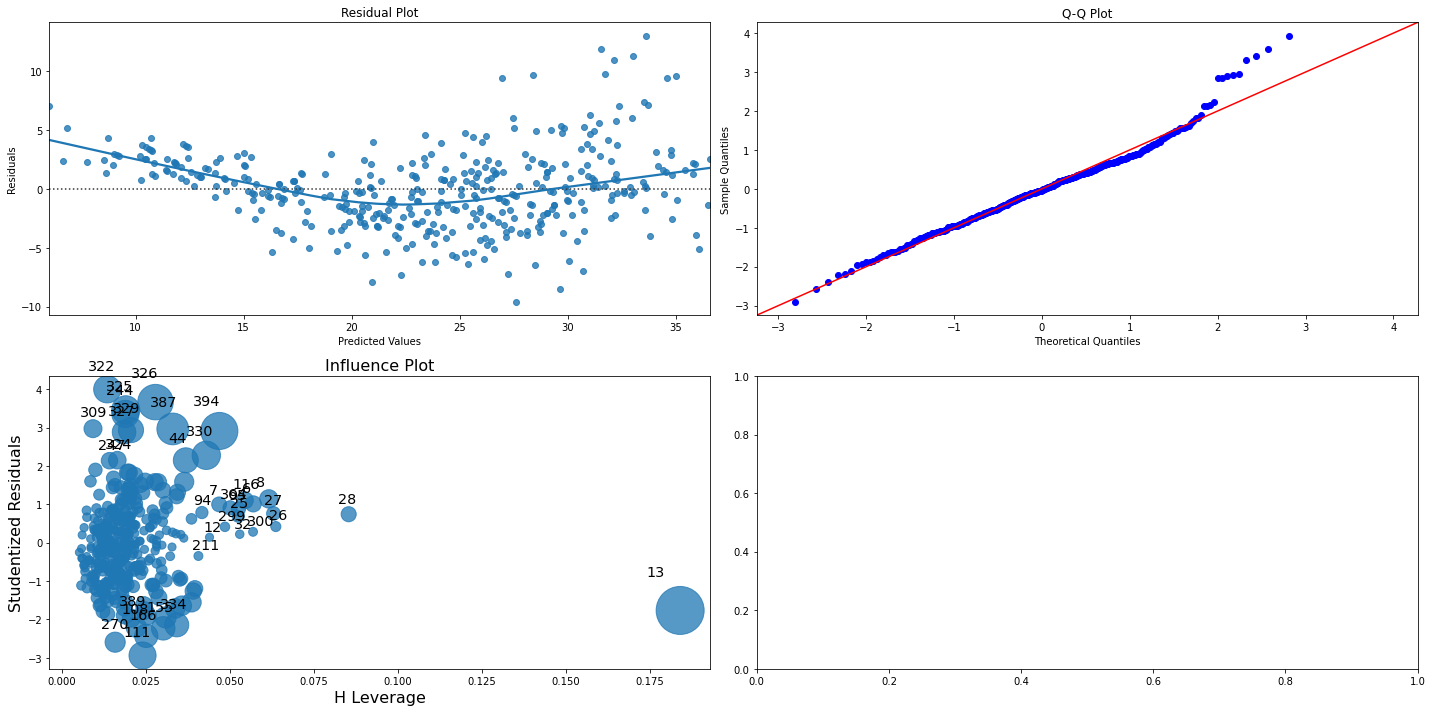

In [62]:
fig, ax = plt.subplots(2, 2)
fig = sns.residplot(x=mlr_model.fittedvalues, y=mlr_model.resid, lowess=True, ax=ax[0,0])
ax[0,0].set_xlabel("Predicted Values")
ax[0,0].set_ylabel("Residuals")
ax[0,0].set_title("Residual Plot")

fig = sm.qqplot(mlr_model.resid, fit=True, line="45", ax=ax[0,1])
ax[0, 1].set_title("Q-Q Plot")

fig = sm.graphics.influence_plot(mlr_model, ax=ax[1,0])
plt.tight_layout()

### Added-variable plots
Since we have a multiple linear regression setting, studying the relationship between each predictor and the response independently may not be informative, because it doesn't take into consideration the effect of the other predictors. For example, if we have 2 highly correlated predictors, both may have a relationship with the response, but in the presence of one, the other may have little or no effect at all. This is known as omitted variable bias, where a relevant predictor is not present in the model, and it's effect is attributed to the other predictors present. To avoid this, we use a partial regression plot, also known as added variable plot, where the y-axis is the residuals of regressing the response on all other predictor except the one we are interested in, and the x-axis is the residuals of regressing the predictor we are interested in on all other predictors. A non-horizontal line fitted on this scatter plot indicates that the predictor is adding information to the model not explained by other predictors. We can see this present clearly in weight and year, and slightly in other predictors like origin and displacement.

A very informative answer on added-variable plots: https://stats.stackexchange.com/a/125575

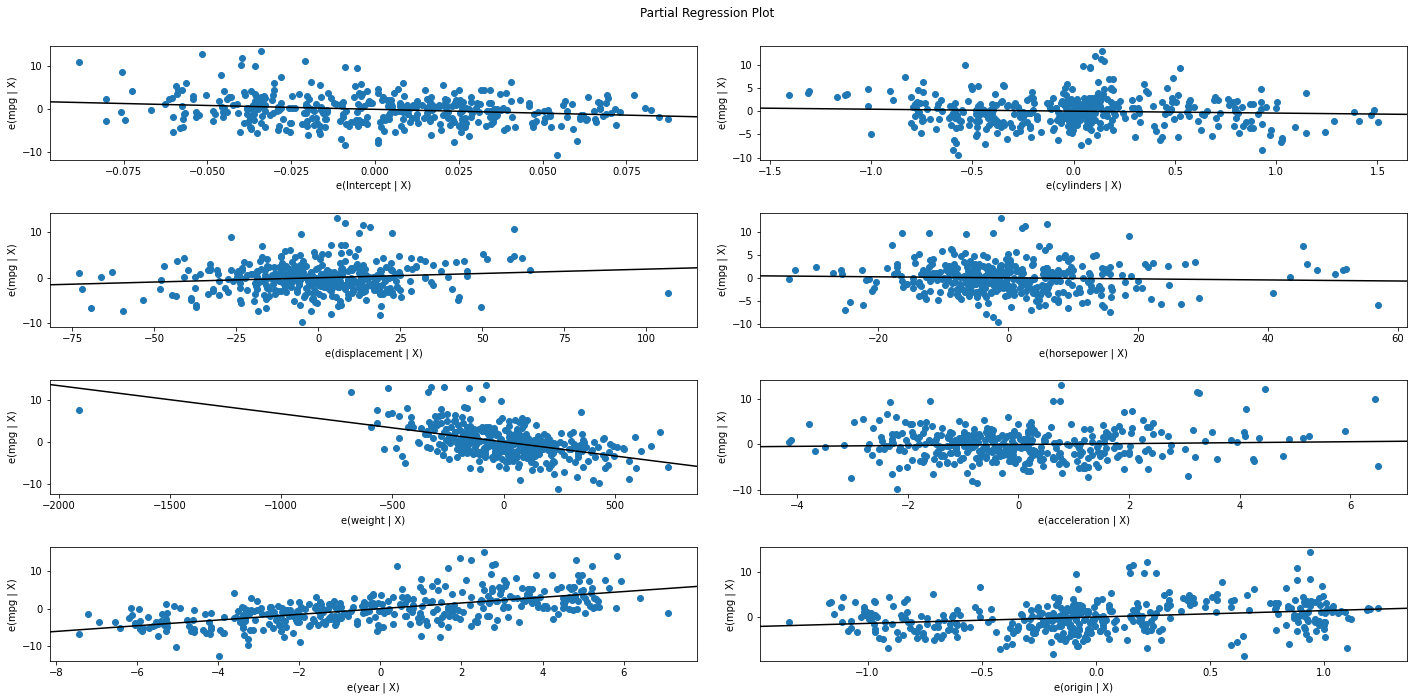

In [58]:
fig = sm.graphics.plot_partregress_grid(mlr_model)
fig.tight_layout(pad=2.0)

## Selecting Features
Since many of the included features are not significant, we can rely on the added-variable plots to choose weight, year, origin, and displacement to proceed with them. We can see that with this reduced feature set, we get an R-sqaured score of 0.818, with only 0.03 reduction compared to the previous model. Another obserbation is that the p-value for the displacement predictor increased, indicating that it might be strongly correlated with one of the present predictor and may also be removed. 

In [66]:
feature_cols = ['weight','year', 'displacement', 'origin']

all_columns = "+".join(feature_cols)

mlr_model = ols(formula=f"mpg ~ {all_columns}", data=auto_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     442.2
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          5.29e-144
Time:                        14:14:18   Log-Likelihood:                -1043.3
No. Observations:                 398   AIC:                             2097.
Df Residuals:                     393   BIC:                             2117.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -18.5449      3.984     -4.654   

## Adding interaction terms
We try all possible combinations of two-way interactions between reduced set of predictors, and we can see that the R-squared increases from 0.82 to 0.862. However, many of these interaction terms are statistically insignificant and could be removed. 

In [70]:
from itertools import combinations
interactions = []

for x,y in combinations(feature_cols, 2):
    interactions.append((x, y))
    
interactions

[('weight', 'year'),
 ('weight', 'displacement'),
 ('weight', 'origin'),
 ('year', 'displacement'),
 ('year', 'origin'),
 ('displacement', 'origin')]

In [71]:
for x, y in interactions:
    auto_df[f"{x}*{y}"] = auto_df[x]*auto_df[y]
    
interaction_str = "+".join([f"{x}*{y}" for x, y in interactions])

In [72]:
mlr_model = ols(formula=f"mpg ~ {all_columns} + {interaction_str}", data=auto_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     240.9
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          2.23e-159
Time:                        14:17:02   Log-Likelihood:                -989.07
No. Observations:                 398   AIC:                             2000.
Df Residuals:                     387   BIC:                             2044.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -22.9510    

## Adding Nonlinearity
From the scatterplot, we can see that the relationship between weight and mpg is nonlinear, therefore we can try a transformation like power of 2. It helped increase the R-squared score to 86.2.

In [73]:
import numpy as np

mlr_model = ols(formula=f"mpg ~ {all_columns} + {interaction_str} + np.power(weight, 2)", data=auto_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     219.0
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          2.29e-158
Time:                        14:18:03   Log-Likelihood:                -988.61
No. Observations:                 398   AIC:                             2001.
Df Residuals:                     386   BIC:                             2049.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -18.2113    

# Carseats Dataset

In [74]:
carseat_df = pd.read_csv(r"datasets\carseats.csv")
carseat_df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


## Fit a multiple  regression model to predict Sales using Price, Urban, and US.

In [75]:
import numpy as np

mlr_model = ols(formula=f"Sales ~ Price + Urban + US", data=carseat_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           2.39e-23
Time:                        14:18:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0435      0.651     20.036   

## Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

For every unit increase in price, holding other predictors constant, the sales decrease by -0.05. If US is True, then sales increase by 1.2. If Urban is True, then sales decrease by 0.0219.

## For which of the predictors can you reject the null hypothesis H0 : βj = 0?
For Urban, the p-value is 0.936 which means we can accept the null hypotheses. For the other two predictors, we can reject the null hypothesis.

## Fit new model only with predictors associated with outcome 

In [95]:
mlr_model = ols(formula=f"Sales ~ Price + US", data=carseat_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Wed, 08 Jun 2022   Prob (F-statistic):           2.66e-24
Time:                        15:06:48   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.0

## Confidence intervals

In [96]:
print(mlr_model.conf_int())

                  0          1
Intercept  11.79032  14.271265
US[T.Yes]   0.69152   1.707766
Price      -0.06476  -0.044195


## Diagnostic Plots
In the residual vs fitted values plot, there doesn't seem to be a pattern in the residuals so the assumptions hold. Similarly, in the QQ-plot, the residuals are lined on the straight line, which means they are in fact normally distributed. Finally, in the influence plot, we can see some influential high leverage and outlier points which may be affecting our model.

C:\Users\amrsh\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


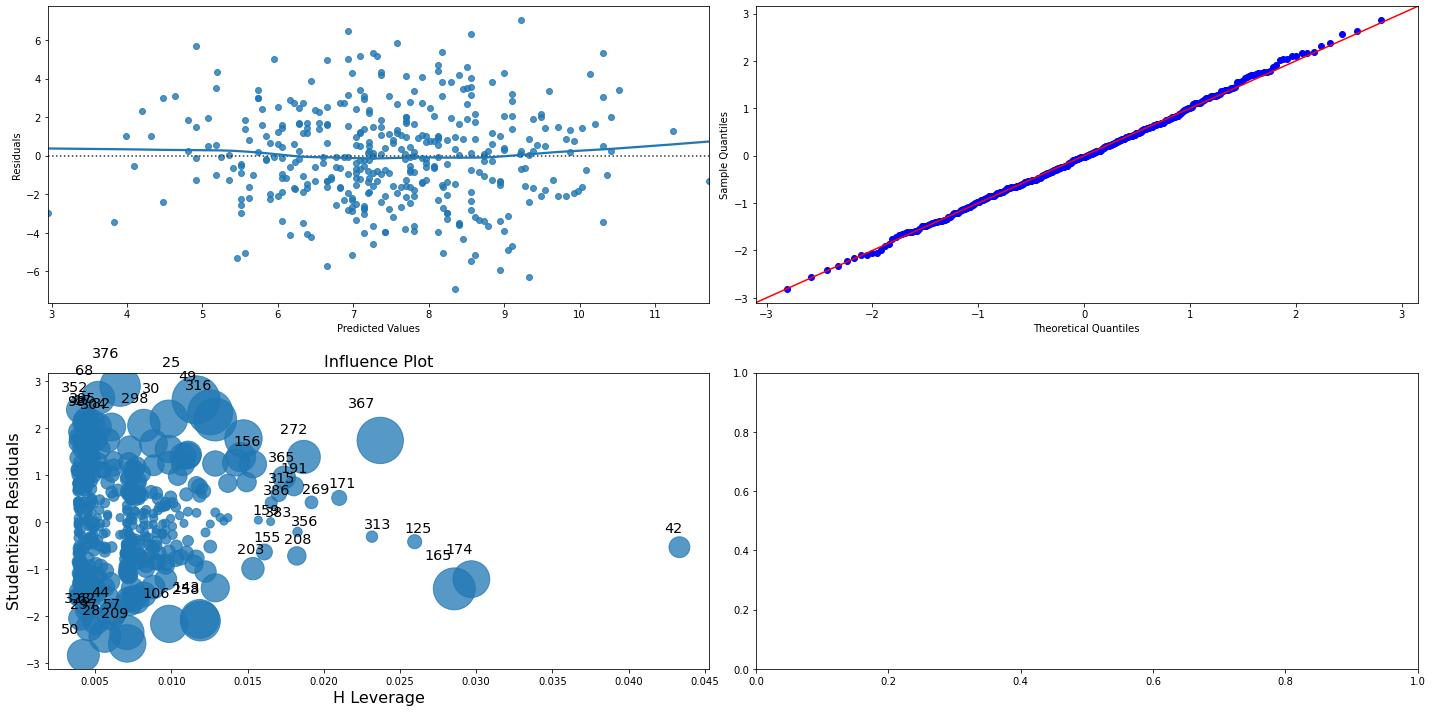

In [99]:
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig = sns.residplot(x=mlr_model.fittedvalues, y=mlr_model.resid, lowess=True, ax=ax[0,0])
ax[0,0].set_xlabel("Predicted Values")
ax[0,0].set_ylabel("Residuals")

fig = sm.qqplot(mlr_model.resid, fit=True, line="45", ax=ax[0,1])

fig = sm.graphics.influence_plot(mlr_model, ax=ax[1,0])
plt.tight_layout()

# Collinearity

In [79]:
import numpy as np

x1 = np.random.uniform(size=100)
x2 = 0.5 * x1 + np.random.normal(size=100) / 10

y = 2 + 2 * x1 + 0.3 * x2 + np.random.normal(size=100)

C:\Users\amrsh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

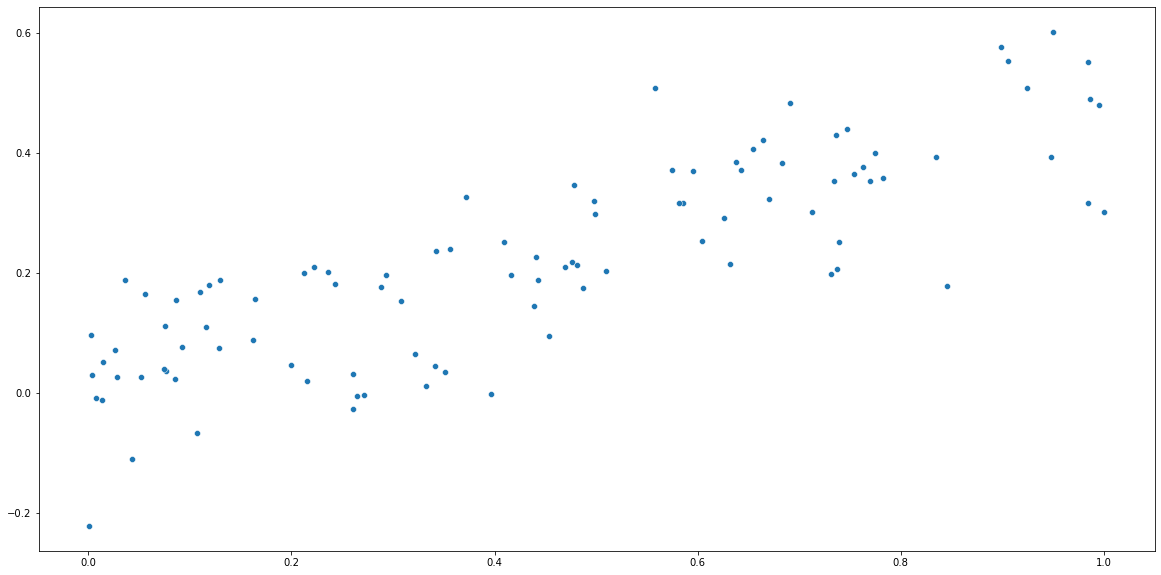

In [80]:
import seaborn as sns

sns.scatterplot(x1, x2)

## C) Using this data, fit a least squares regression to predict y using x1 and x2. Describe the results obtained. What are βˆ0, βˆ1, and βˆ2? How do these relate to the true β0, β1, and β2? Can you reject the null hypothesis H0 : β1 = 0? How about the null hypothesis H0 : β2 = 0?

By fitting the model, we can see that the coefficients of intercept, x1, and x2 are 1.93, 2.68, and -0.815 respectively. We can also see that thte p value of x2 is high, suggesting that it's contribution to the prediction could be due to random chance and that the null hypothesis should be accepted.

In [82]:
col_df = pd.DataFrame({'x1':x1,'x2':x2,'y':y})

mlr_model = ols(formula=f"y ~ x1 + x2", data=col_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     17.38
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           3.53e-07
Time:                        14:21:04   Log-Likelihood:                -156.19
No. Observations:                 100   AIC:                             318.4
Df Residuals:                      97   BIC:                             326.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9315      0.210      9.216      0.0

## D) Now fit a least squares regression to predict y using only x1. Comment on your results. Can you reject the null hypothesis H0 : β1 = 0?

Removing x2 resulted in a very slight decrease in the R-sqaured score equaling 0.03, meaning that x2 had indeed a negligible contribution on the prediction of the output. The p-value of x1 is very low therefore we can reject the null hypothesis.

In [83]:
mlr_model = ols(formula=f"y ~ x1", data=col_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     34.53
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           5.79e-08
Time:                        14:21:23   Log-Likelihood:                -156.41
No. Observations:                 100   AIC:                             316.8
Df Residuals:                      98   BIC:                             322.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9203      0.208      9.219      0.0

## E) Now fit a least squares regression to predict y using only x2. Comment on your results. Can you reject the null hypothesis H0 : β1 = 0?

Predicting using x2 only resulted in an R-sqaured score of 0.151, much less than what we got using x1. By only including x2 in the model, we get a very low p-value suggesting that we can reject the null hypothesis. 

In [84]:
mlr_model = ols(formula=f"y ~ x2", data=col_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     17.43
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           6.46e-05
Time:                        14:21:43   Log-Likelihood:                -163.32
No. Observations:                 100   AIC:                             330.6
Df Residuals:                      98   BIC:                             335.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2544      0.205     10.983      0.0

## F) Do the results obtained in (C)–(E) contradict each other? Explain your answer.
No they don't. The model in C suggests that x2 is not strongly associated with y in the presence of x1. This is due to the strong correlation between x1 and x2, because x2 will not be adding more information than what x1 already added. However, in the absence of x1, x2 is significant since it still associated with y and provides information to predict it. This is due to the omitted variable bias discussed earlier.

## Now suppose we obtain one additional observation, which was unfortunately mismeasured. Re-fit the linear models from (c) to (e) using this new data. What effect does this new observation have on the each of the models? In each model, is this observation an outlier? A high-leverage point? Both? Explain your answers

In [85]:
col_df.loc[len(col_df.index)] = [0.1, 0.8, 6] 
col_df.head()

,x1,x2,y
0,0.737254,0.206196,4.116825
1,0.002707,0.096511,1.452060
2,0.557884,0.507729,4.386034
3,0.905470,0.553074,4.021320
4,0.415694,0.197036,3.920840


### Model including x1 and x2
By visualizing the points again, we can see the last added point located far from all the other points, indicating that it's an outlier. After fitting the model, we can see that it decrease the R-sqaured score to 0.236.

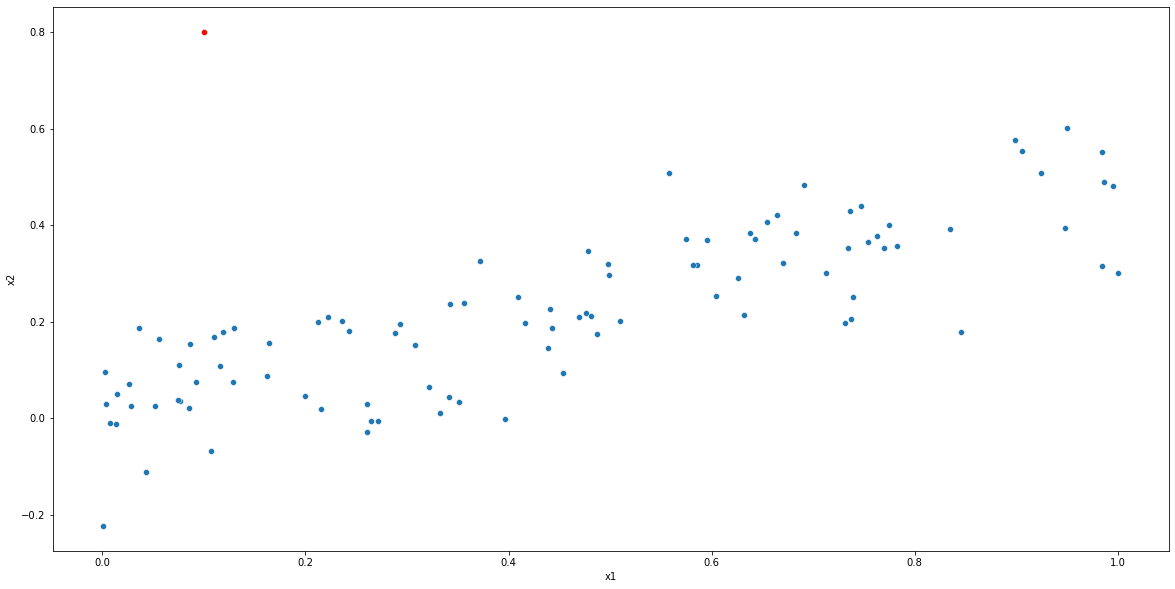

In [86]:
ax = sns.scatterplot(x='x1', y='x2', data=col_df)
ax = sns.scatterplot(x=[0.1], y=[0.8], color='r')

In [87]:
mlr_model = ols(formula=f"y ~ x1 + x2", data=col_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     15.13
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           1.88e-06
Time:                        14:23:28   Log-Likelihood:                -161.66
No. Observations:                 101   AIC:                             329.3
Df Residuals:                      98   BIC:                             337.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9740      0.217      9.084      0.0

### Model including x1 only


By plotting the x1 vs y, we can see that the y value for the newly added point (red) is far from that of all other points, indicating that it's an outlier. In the diagnostic plots, we can see that the residual of this point is significantly higher than all other points due to the wrong measurement of y, which resulted in the decrease of the R-sqaured score.

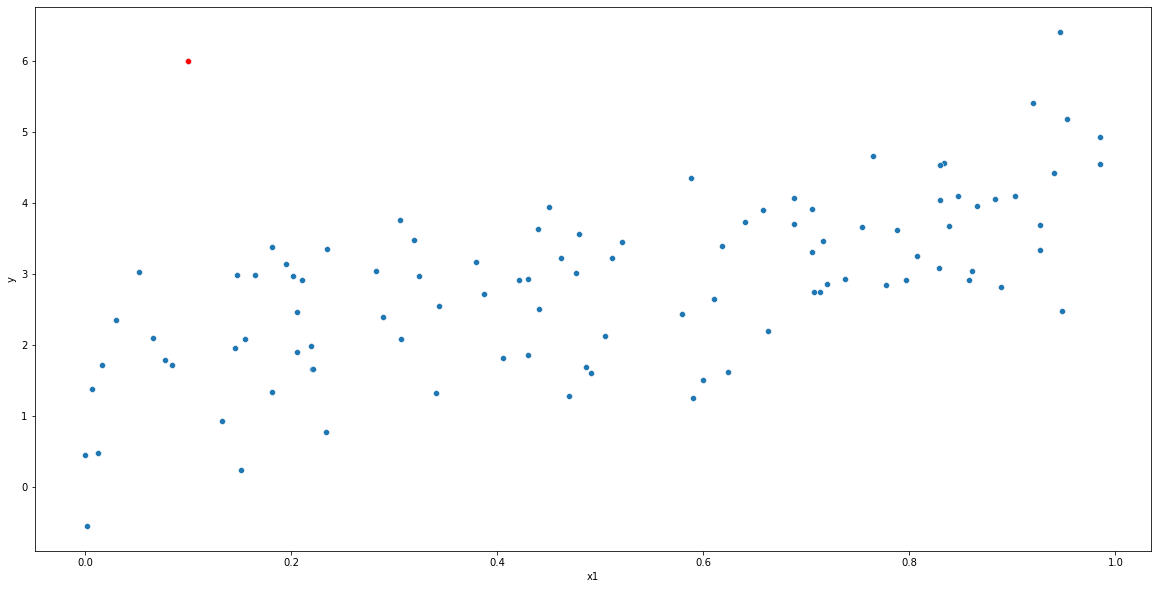

In [49]:
ax = sns.scatterplot(x='x1', y='y', data=col_df)
ax = sns.scatterplot(x=[0.1], y=[6], color='r')
ax.set(xlabel='x1', ylabel='y')
plt.show()

In [88]:
mlr_model = ols(formula=f"y ~ x1", data=col_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     28.01
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           7.26e-07
Time:                        14:23:59   Log-Likelihood:                -162.67
No. Observations:                 101   AIC:                             329.3
Df Residuals:                      99   BIC:                             334.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0213      0.216      9.369      0.0

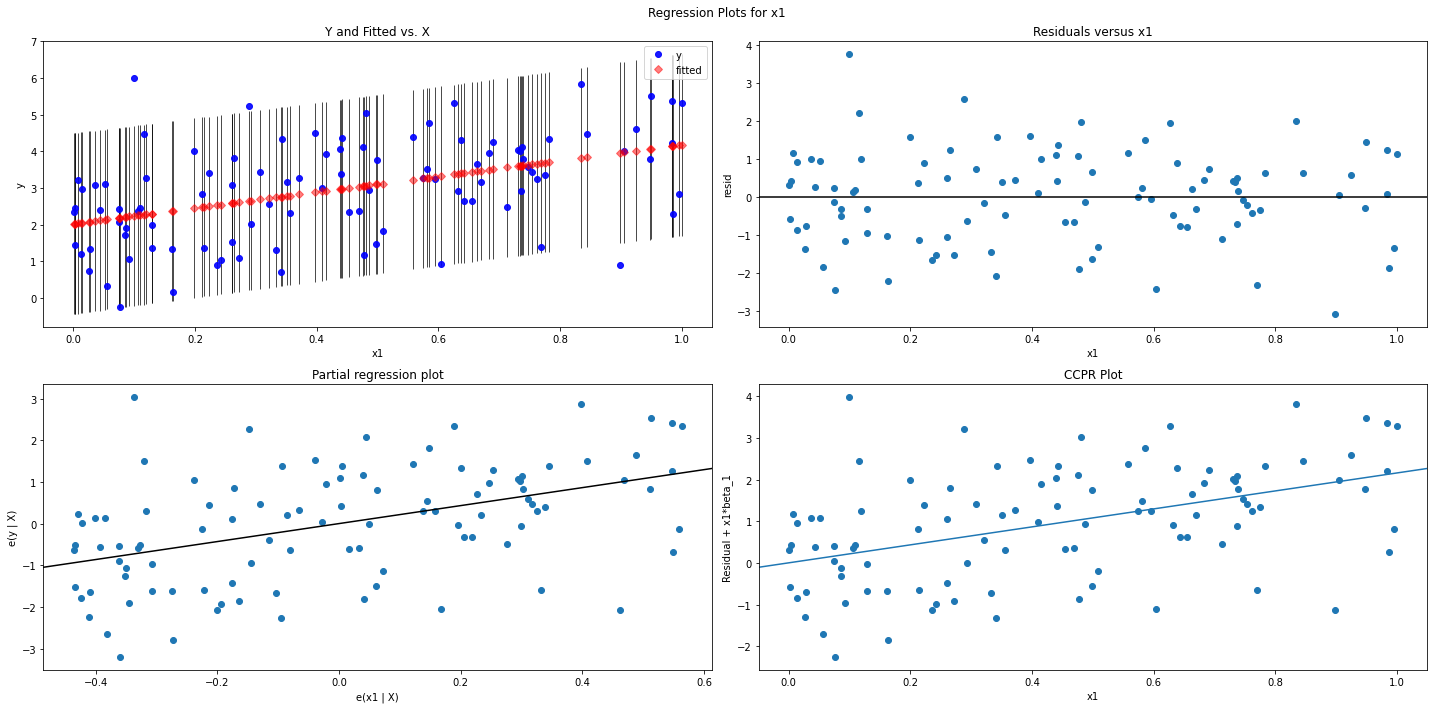

In [89]:
fig = sm.graphics.plot_regress_exog(mlr_model, "x1")
fig.tight_layout(pad=1.0)

## Model including x2 only
By plotting x2 vs. y, we can see the red dot having a value in x2 greater than all other points but it still follows the general trend of points, indicating that it might be a high leverage point. 

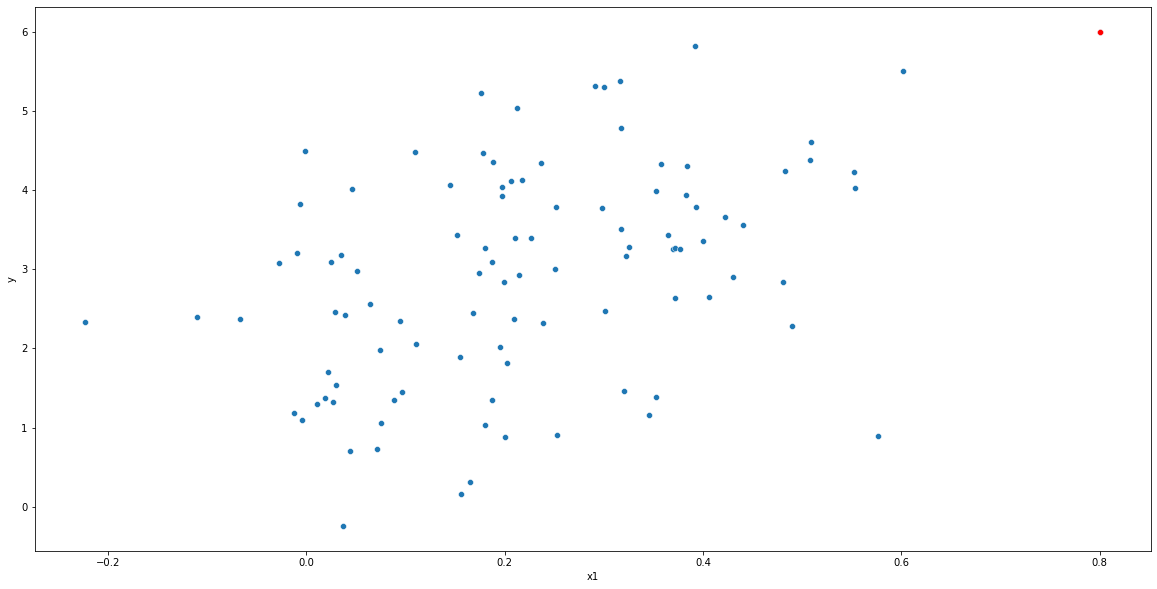

In [90]:
ax = sns.scatterplot(x='x2', y='y', data=col_df)
ax = sns.scatterplot(x=[0.8], y=[6], color='r')
ax.set(xlabel='x1', ylabel='y')
plt.show()

In [91]:
mlr_model = ols(formula=f"y ~ x2", data=col_df).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     22.51
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           7.04e-06
Time:                        14:25:18   Log-Likelihood:                -164.91
No. Observations:                 101   AIC:                             333.8
Df Residuals:                      99   BIC:                             339.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2155      0.201     11.024      0.0